<a href="https://colab.research.google.com/github/O-Kpy/Project/blob/main/tabular_playground_series_jul_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import math
plt.style.use('ggplot')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_test.csv')
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
train.shape, test.shape

((7111, 12), (2247, 9))

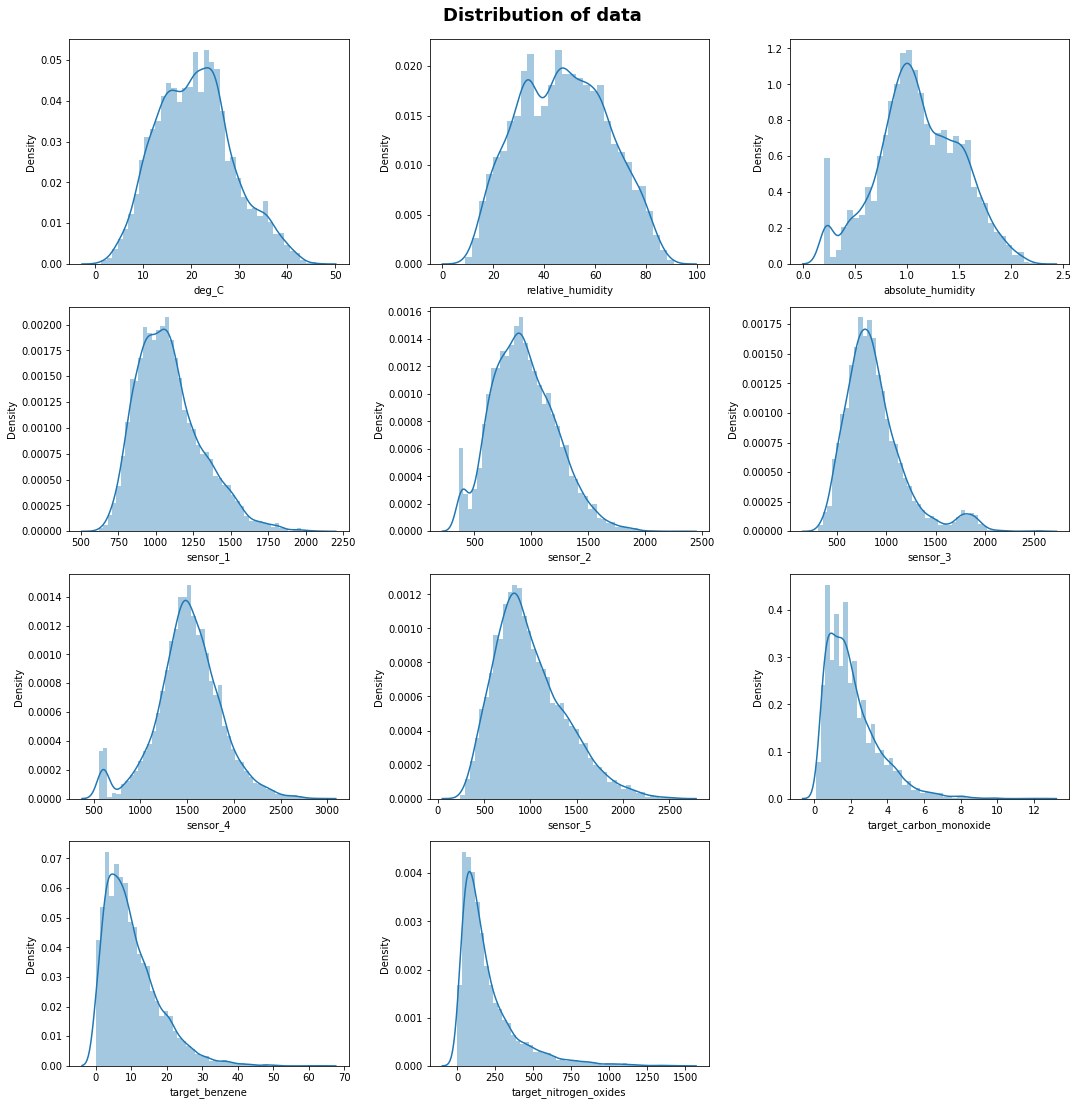

In [ ]:
plt.figure(figsize=(15,15))
for i,j in enumerate(train.select_dtypes('float').columns):
  plt.subplot(4,3, i+1)
  sns.distplot(train[j])
plt.suptitle('Distribution of data', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()


# target label이 3개 있는 시계열 데이터


date_time == 센서가 측정값을 내린 시간

deg_C == 온도

relative_humidity == 상대 습도 > 온도에 따라 달라짐

absolute_humidity == 절대 습도 > 온도가 증감 되더라도 가습 되지 않는 이상 절대 습도는 일정함

sensor_x == 센서 이름



# Feature engineering

In [ ]:
# 피쳐 엔지니어링 ver.1
all_data = pd.concat([train, test])

all_data['date_time'] = pd.to_datetime(all_data['date_time'])

months = all_data["date_time"].dt.month[:len(train)]

all_data["hour"] = all_data["date_time"].dt.hour
all_data["working_hours"] =  all_data["hour"].isin(np.arange(8, 21, 1)).astype("int")
all_data["is_weekend"] = (all_data["date_time"].dt.dayofweek >= 5).astype("int")
all_data['satday'] = (all_data.date_time.dt.weekday==5).astype("int")
all_data['hr'] = all_data.date_time.dt.hour*60+all_data.date_time.dt.minute

all_data["s1-6"] = all_data["sensor_1"] - all_data["sensor_1"].shift(periods=6, fill_value=0)
all_data["s2-6"] = all_data["sensor_2"] - all_data["sensor_2"].shift(periods=6, fill_value=0)
all_data["s3-6"] = all_data["sensor_3"] - all_data["sensor_3"].shift(periods=6, fill_value=0)
all_data["s4-6"] = all_data["sensor_4"] - all_data["sensor_4"].shift(periods=6, fill_value=0)
all_data["s5-6"] = all_data["sensor_5"] - all_data["sensor_5"].shift(periods=6, fill_value=0)
all_data["maximum_hours"] =  all_data["hour"].isin([8, 9, 17, 18, 19, 20]).astype("int")
all_data.drop(columns = 'hour', inplace = True)

all_data['time'] = all_data['date_time'].astype(np.int64)//10**9
all_data['SMC'] = (all_data['absolute_humidity'] * 100) / all_data['relative_humidity']

In [ ]:
train['date_time'] = pd.to_datetime(train['date_time'], format='%Y-%m-%d %H:%M:%S')
test['date_time'] = pd.to_datetime(test['date_time'], format='%Y-%m-%d %H:%M:%S')

# train['date'] = train['date_time'].dt.date
# test['date'] = test['date_time'].dt.date

# train['month'] = train['date_time'].dt.month  # month넣으면 overfitting ==> 원핫코딩으로 test에 없는 month컬럼을 따로 만들어 주어야 함
# test['month'] = test['date_time'].dt.month

# train['day'] = train['date_time'].dt.day
# test['day'] = test['date_time'].dt.day

train['hour'] = train['date_time'].dt.hour
test['hour'] = test['date_time'].dt.hour

train['weekday'] = train['date_time'].dt.weekday  # weekday를 카테고리로 해볼까
test['weekday'] = test['date_time'].dt.weekday

train['weekend'] = train['weekday'].apply(lambda x:1 if x in [5,6] else 0)
test['weekend'] = test['weekday'].apply(lambda x:1 if x in [5,6] else 0)

train['is_workingtime'] = train['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)
test['is_workingtime'] = test['hour'].apply(lambda x:1 if x in range(8, 21, 1) else 0)

train['time'] = train['date_time'].astype(np.int64)//10**9
test['time'] = test['date_time'].astype(np.int64)//10**9

month = train["date_time"].dt.month[:len(train)]  # LeaveOneGroupOut

In [ ]:
# SMC(포화 수증기량)

train['SMC'] = (train['absolute_humidity'] * 100) / train['relative_humidity']
test['SMC'] = (test['absolute_humidity'] * 100) / test['relative_humidity']

# dew point(이슬점)
# def dew_point(df):

#  b = 17.62
#  c = 243.12

#  gamma = (b * df['deg_C'] /(c + df['deg_C'])) + np.log(df['relative_humidity'] / 100.0)
#  dewpoint = (c * gamma) / (b - gamma)

#  return dewpoint

# train['dewpoint'] = dew_point(train)
# test['dewpoint'] = dew_point(test)

# 이슬점과 포화 수증기량 성능 안좋아짐

In [ ]:
# object화
train['weekday'] = train['weekday'].astype('object')
test['weekday'] = test['weekday'].astype('object')

train['weekend'] = train['weekend'].astype('object')
test['weekend'] = test['weekend'].astype('object')

train['is_workingtime'] = train['is_workingtime'].astype('object')
test['is_workingtime'] = test['is_workingtime'].astype('object')

train['hour'] = train['hour'].astype('object')
test['hour'] = test['hour'].astype('object')

# train['day'] = train['day'].astype('object')
# test['day'] = test['day'].astype('object')

# train['month'] = train['month'].astype('object')
# test['month'] = test['month'].astype('object')

In [ ]:
# train = pd.get_dummies(train, columns=['month'])
# test = pd.get_dummies(test, columns=['month'])

Text(0.5, 1.0, 'date vs target')

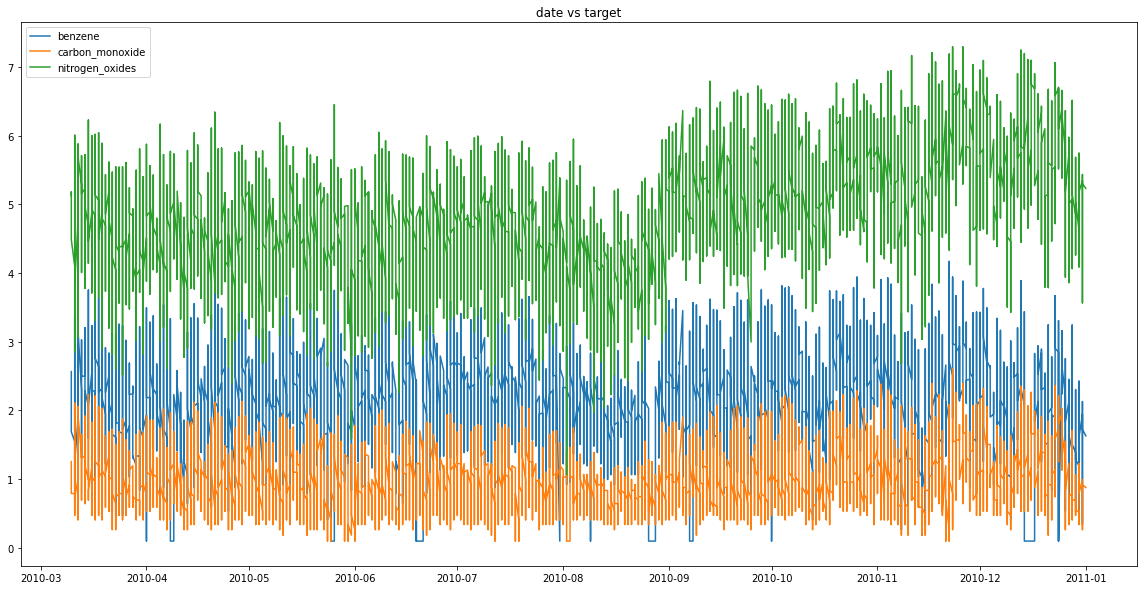

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(train['date'], np.log1p(train['target_benzene']), label='benzene')
plt.plot(train['date'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.plot(train['date'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('date vs target')

Text(0.5, 1.0, 'deg_C vs target')

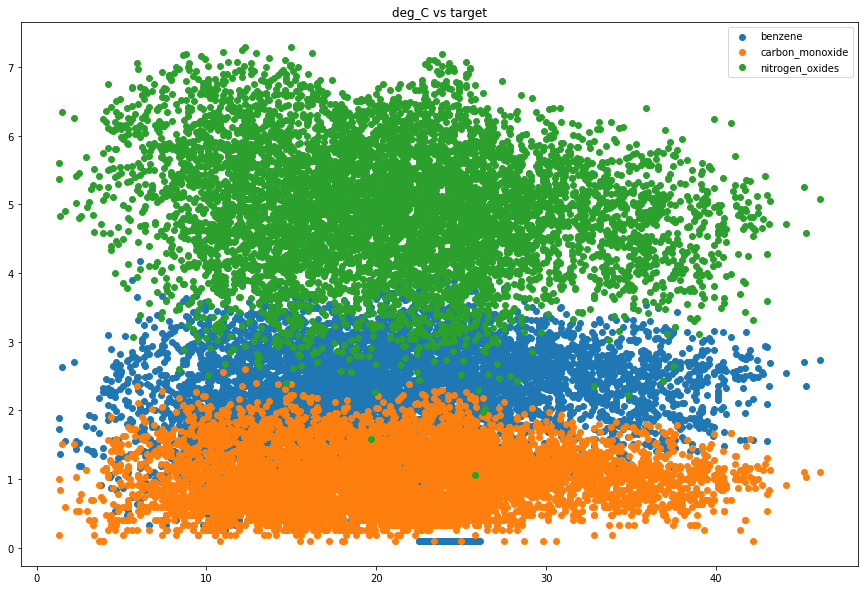

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['deg_C'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['deg_C'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['deg_C'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('deg_C vs target')

Text(0.5, 1.0, 'relative_humidity vs target')

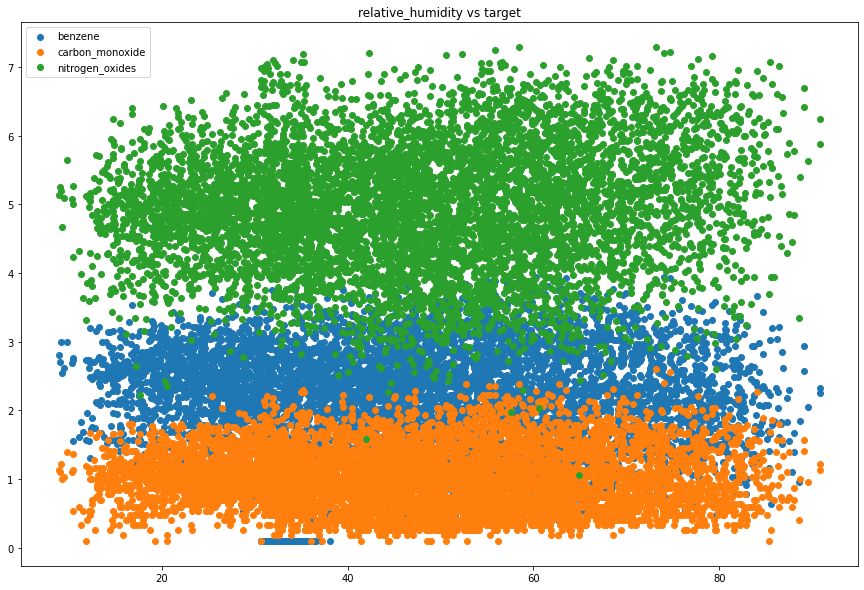

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['relative_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['relative_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['relative_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('relative_humidity vs target')

Text(0.5, 1.0, 'absolute_humidity vs target')

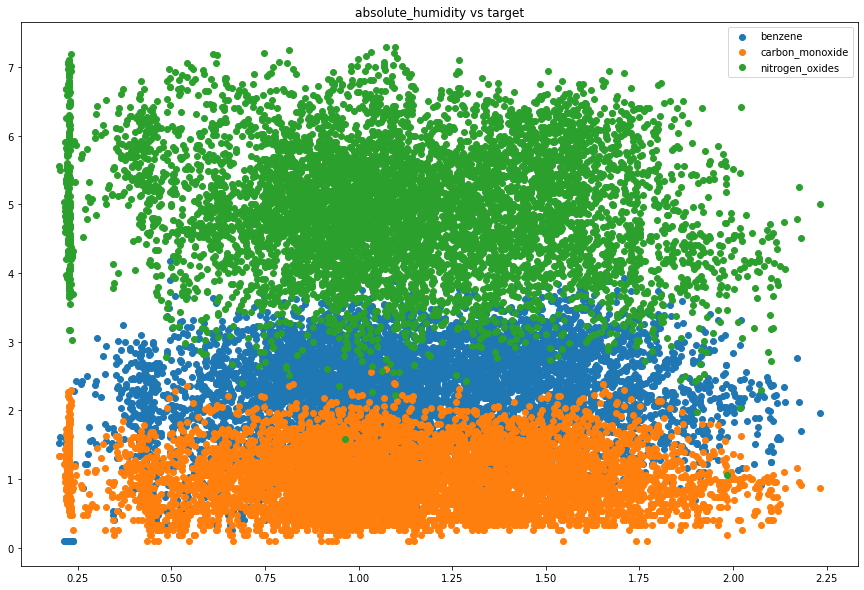

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(train['absolute_humidity'], np.log1p(train['target_benzene']), label='benzene', )
plt.scatter(train['absolute_humidity'], np.log1p(train['target_carbon_monoxide']), label='carbon_monoxide')
plt.scatter(train['absolute_humidity'], np.log1p(train['target_nitrogen_oxides']), label='nitrogen_oxides')
plt.legend()
plt.title('absolute_humidity vs target')

# 시각화를 통해
nitrigen_oxides는 날짜의 영향을 받는다(== 날씨의 영향을 받는다)

bengene, carbon은 날짜의 영향을 받지 않는듯하다(== 날씨의 영향을 덜 받는다)



---

# 시계열별 EDA



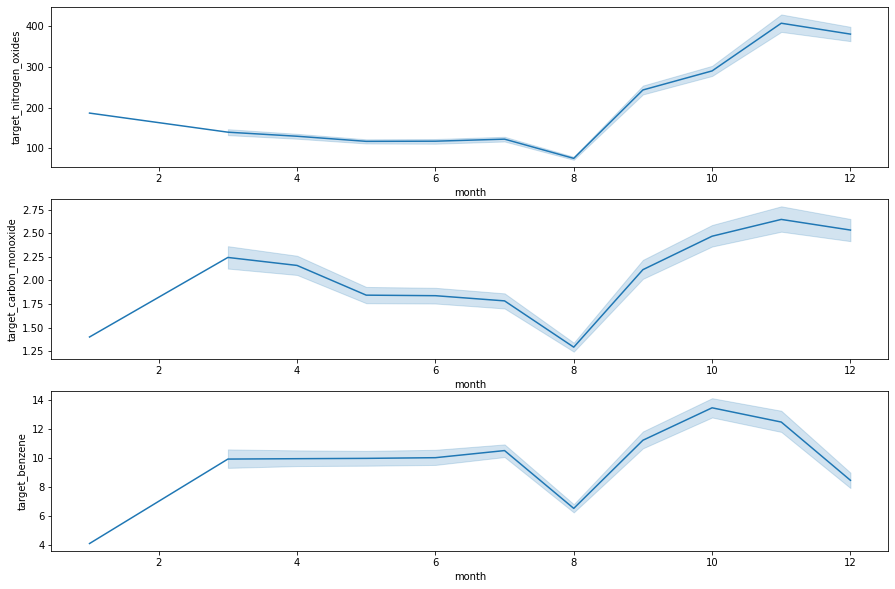

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(15,10))
sns.lineplot(train['month'], train['target_nitrogen_oxides'], ax=ax[0])
sns.lineplot(train['month'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['month'], train['target_benzene'], ax=ax[2])

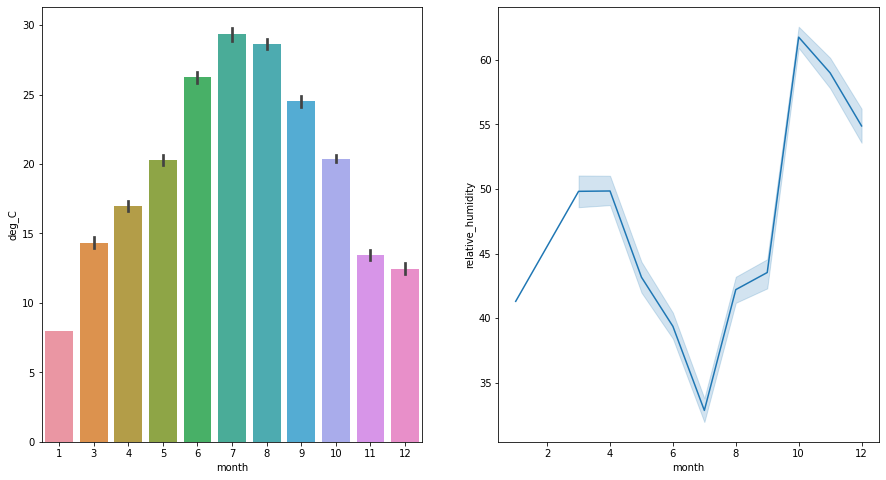

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
sns.barplot(train['month'], train['deg_C'], ax=ax[0])
sns.lineplot(train['month'], train['relative_humidity'], ax=ax[1])

여름에는 덥고 건조하고 겨울에는 춥고 습윤하다 ==> 지중해 날씨??

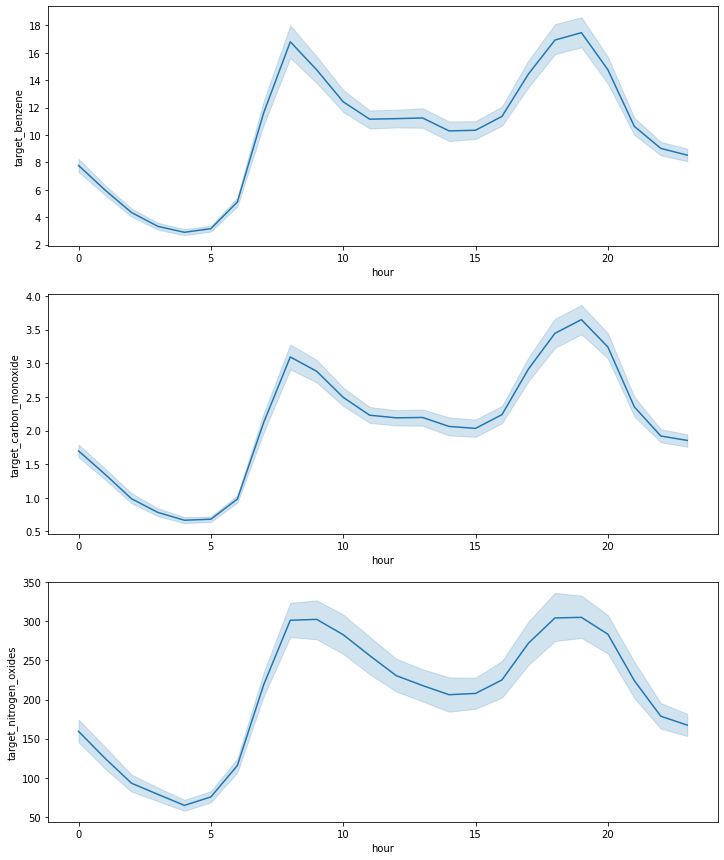

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.lineplot(train['hour'], train['target_benzene'], ax=ax[0])
sns.lineplot(train['hour'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['hour'], train['target_nitrogen_oxides'], ax=ax[2])

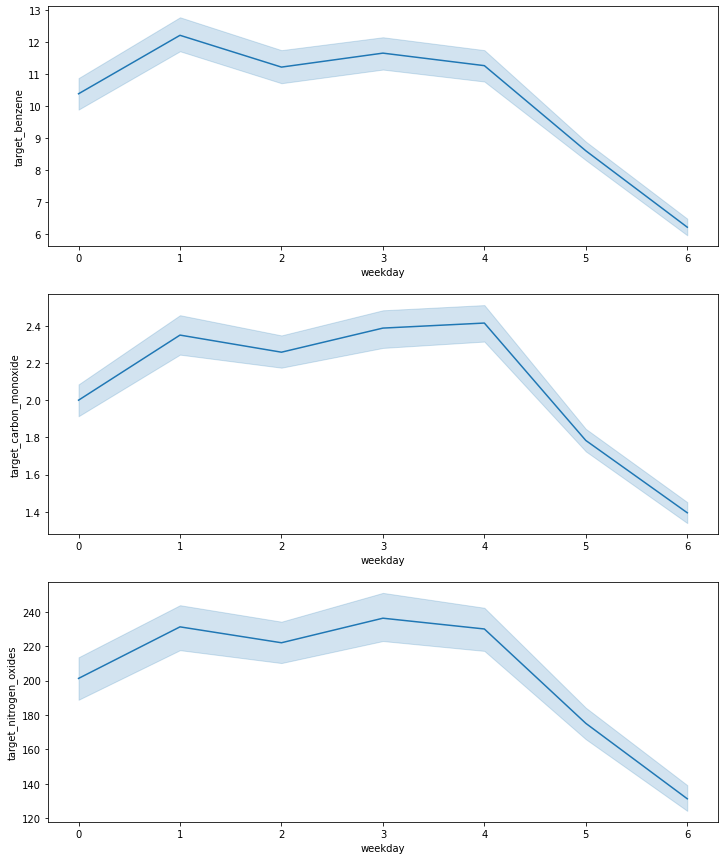

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.lineplot(train['weekday'], train['target_benzene'], ax=ax[0])
sns.lineplot(train['weekday'], train['target_carbon_monoxide'], ax=ax[1])
sns.lineplot(train['weekday'], train['target_nitrogen_oxides'], ax=ax[2])

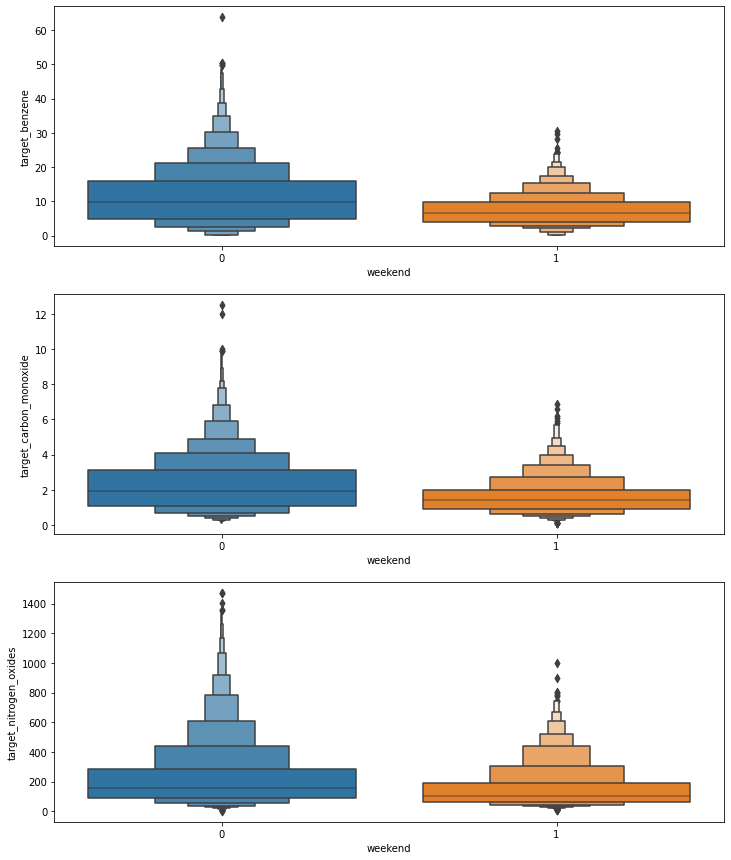

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(12,15))
sns.boxenplot(train['weekend'], train['target_benzene'], ax=ax[0])
sns.boxenplot(train['weekend'], train['target_carbon_monoxide'], ax=ax[1])
sns.boxenplot(train['weekend'], train['target_nitrogen_oxides'], ax=ax[2])

hour 변수로 시각화해서 알 수 있는 것 ==> 시간 별로 target값이 불규칙하다 ==> 유의미한 column이다.

weekday 변수로 시각화해서 알 수 있는 것 ==> 유의미한 차이가 관찰됨 ==> 유의미한 column

weekend 변수로 시각화해서 알 수 있는 것 ==> 차이가 있다. ==> 유의미한 column

* 시계열 변수는 hour, weekday, weekend 변수만 챙겨간다.

---

# 모델링(modeling) 시작
 - 라이브러리 설치(optuna, catboost, eli5)


In [ ]:
!pip install eli5
!pip install catboost
!pip install optuna

     |████████████████████████████████| 106 kB 5.1 MB/s 
     |████████████████████████████████| 69.2 MB 9.0 kB/s 
     |████████████████████████████████| 301 kB 5.0 MB/s 
     |████████████████████████████████| 80 kB 5.3 MB/s 
     |████████████████████████████████| 164 kB 9.0 MB/s 
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 141 kB 9.5 MB/s 
     |████████████████████████████████| 111 kB 10.6 MB/s 
     |████████████████████████████████| 49 kB 4.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=a9682ad0ee3a9235c2f0f85ad1af63edfae53281ea9ae9aa5ce083b350df2b48
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# 설치 완료

In [ ]:
import catboost
import xgboost
import lightgbm as lgbm
import optuna
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate, train_test_split, LeaveOneGroupOut
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn.preprocessing import robust_scale, StandardScaler, MinMaxScaler
rmsle = make_scorer(mean_squared_log_error, greater_is_better=False)

# Data Split(x_train, y_train) ==> KFOLD, StratifiedKFold, LeaveOneGroupOut 사용 할 것

In [ ]:
# ver.1 data split
train = all_data.loc[all_data['target_carbon_monoxide'].notnull()]
test = all_data.loc[all_data['target_carbon_monoxide'].isnull()]

x_train = train.drop(columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
y1_train = np.log1p(train['target_carbon_monoxide'])
y2_train = np.log1p(train['target_benzene'])
y3_train = np.log1p(train['target_nitrogen_oxides'])
x_test = test.drop(columns=['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])

train_col = x_train.columns
test_col = x_train.columns

In [ ]:
# ver.2 data split
x_train = train.drop(columns=['date_time', 'target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides'])
y1_train = np.log1p(train['target_carbon_monoxide'])
y2_train = np.log1p(train['target_benzene'])
y3_train = np.log1p(train['target_nitrogen_oxides'])
x_test = test.drop(columns=['date_time'])

train_col = x_train.columns
test_col = x_train.columns

# 다중 공선성(VIF) 처리를 할까... 고민, 

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

vif = pd.DataFrame()

# Normalize data first
sc = StandardScaler()
scaled_train_df = sc.fit_transform(x_train[x_train.columns])
scaled_test_df = sc.transform(x_test[x_train.columns])

vif['variables'] = x_train.columns
vif['vif_train'] = [variance_inflation_factor(scaled_train_df,i) for i in range(x_train[x_train.columns].shape[1])]
vif['vif_test'] = [variance_inflation_factor(scaled_test_df,i) for i in range(x_test[x_train.columns].shape[1])]
vif.style.background_gradient(cmap='magma')

# In general, a VIF above 10 indicates high correlation and is cause for concern. 
# Some authors suggest a more conservative level of 2.5 or above. 
# Sometimes a high VIF is no cause for concern at all. In this case our vif's for every features is in most cases lower than 10. There is one feature 'sensor_2' in training set which have 12 and two features ('absolute_humidity', 'sensor_4') in test dataset which have 45 and 46 respectively. 
# Feature 'deg_C' and 'sensor_2' in test dataset are also high.One way of dealing with multicollinearity is using PCA to reduce number of features or simple delete one of the features.
# VIF를 줄이기 위해 PCA를 실시해보자

,variables,vif_train,vif_test
0,relative_humidity,44.236010,62.465349
1,absolute_humidity,46.803217,155.874498
2,sensor_1,51.262121,98.670291
3,sensor_2,165.538117,278.958204
4,sensor_3,115.878587,652.905594
5,sensor_4,103.458860,168.355781
6,sensor_5,151.331608,211.904090
7,hour,6.024968,5.913956
8,weekday,inf,223011197473.098907
9,weekend,3.748925,4.391997


In [ ]:
# Normalize 성능이 안좋아진다...
for i in x_train.columns:
  if x_train[i].skew() > 0.5:
    x_train[i] = boxcox1p(x_train[i], boxcox_normmax(x_train[i]+1))
    x_test[i] = boxcox1p(x_test[i], boxcox_normmax(x_test[i]+1))

# 스케일링

In [ ]:
# StandardScaler
sc = StandardScaler().fit(x_train)
x_train = sc.transform(x_train)
x_test = sc.transform(x_test)

In [ ]:
# MinMaxScaler
for i in x_train.select_dtypes(exclude='object').columns:
  sc = MinMaxScaler().fit(x_train[[i]])
  x_train[i] = sc.transform(x_train[[i]])
  x_test[i] = sc.transform(x_test[[i]])

In [ ]:
# robust_scale 성능 안좋음
x_train = pd.DataFrame(robust_scale(x_train), columns=train_col)
x_test = pd.DataFrame(robust_scale(x_test), columns=test_col)

In [ ]:
x_train = pd.DataFrame(x_train, columns=train_col)
x_test = pd.DataFrame(x_test, columns=test_col)

**MinMaxScaler**가 성능이 가장 좋게 나온다.

# 클러스터링
 - 스케일링을 한 이유 : 어떤 센서인지 알 수 없고, 높은 측정량이 좋은 것인지 나쁜 것 인지 알 수 없기 때문에 비지도 학습을 사용 했다.
 - 우선 성능은 좋아졌다.

Text(0.5, 1.0, 'elbow method')

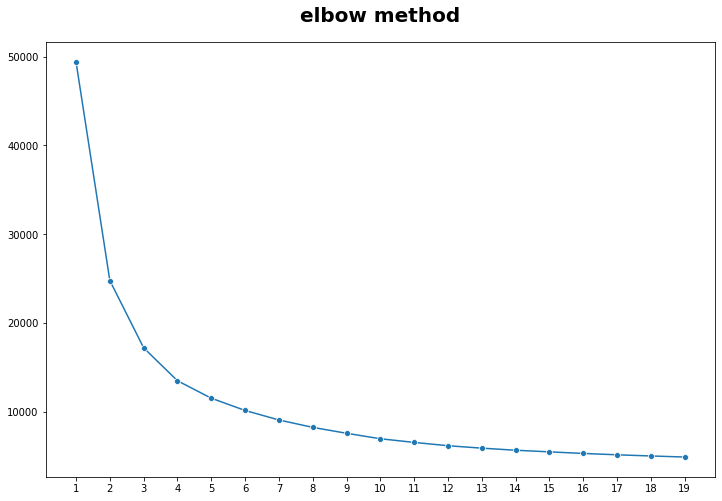

In [ ]:
# sensor 클러스터링

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



train_cl = x_train[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']]
test_cl = x_test[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']]

data_cl = pd.concat([train_cl, test_cl])

cluster={}
for i in range(1, 20, 1):
  km = KMeans(n_clusters=i, max_iter=1000, n_jobs=-1).fit(data_cl)
  cluster[i] = km.inertia_

plt.figure(figsize=(12,8))
sns.lineplot(pd.Series(cluster).index, pd.Series(cluster), marker='o')
plt.xticks(pd.Series(cluster).index)
plt.title('elbow method', fontsize=20, fontweight='bold', pad=20)

In [ ]:
km = KMeans(n_clusters=4, max_iter=1000, n_jobs=-1).fit(data_cl)

x_train['cluster'] = km.predict(train_cl).astype('object')
x_test['cluster'] = km.predict(test_cl).astype('object')

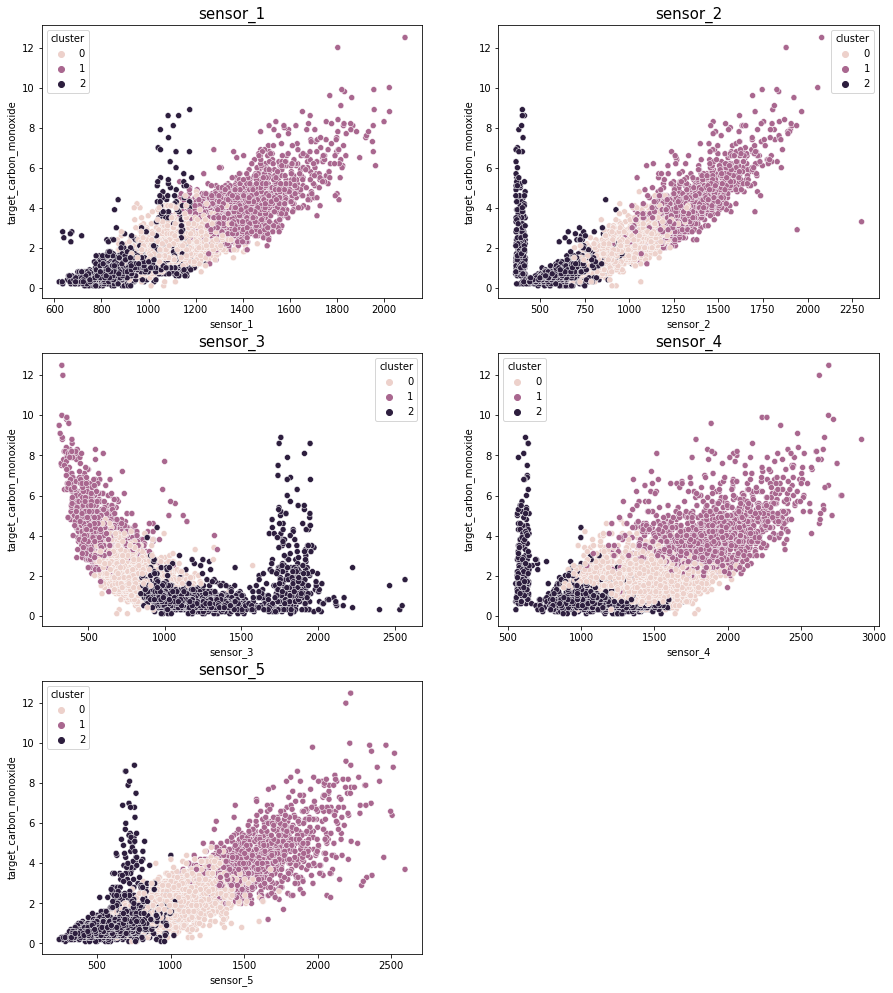

In [ ]:
# clustering 시각화
train['cluster'] = km.predict(train_cl)
test['cluster'] = km.predict(test_cl)

plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_carbon_monoxide'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

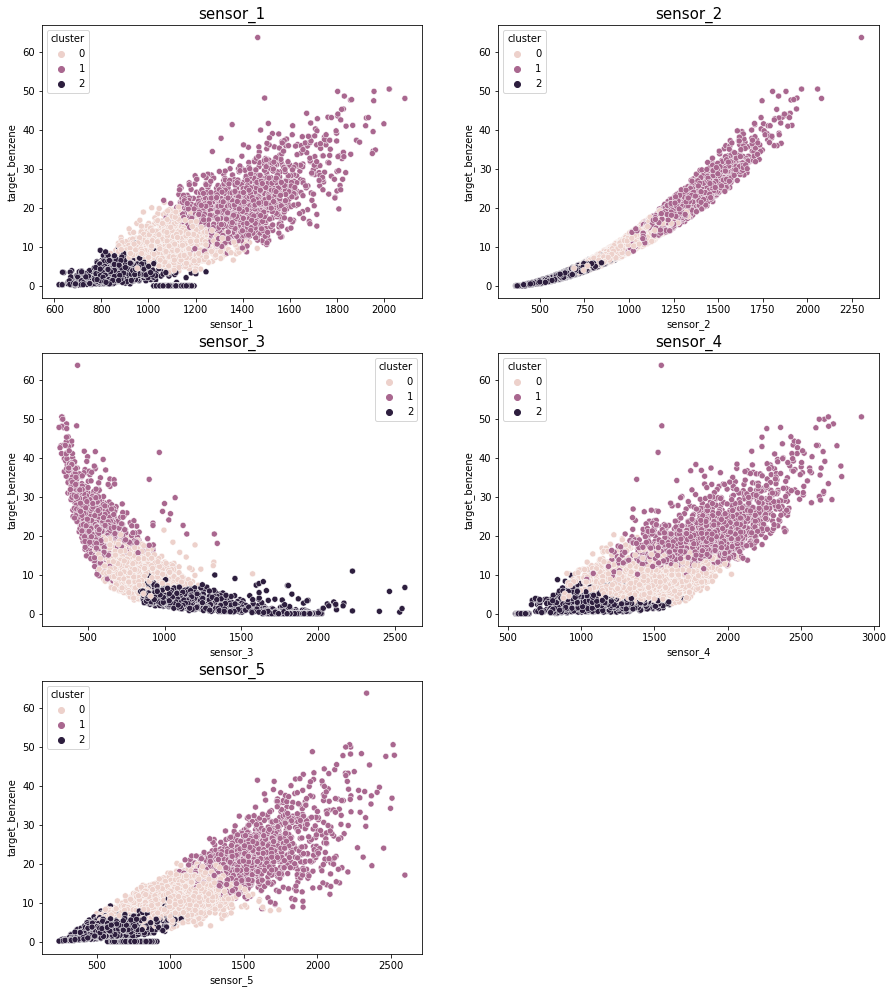

In [ ]:
plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_benzene'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

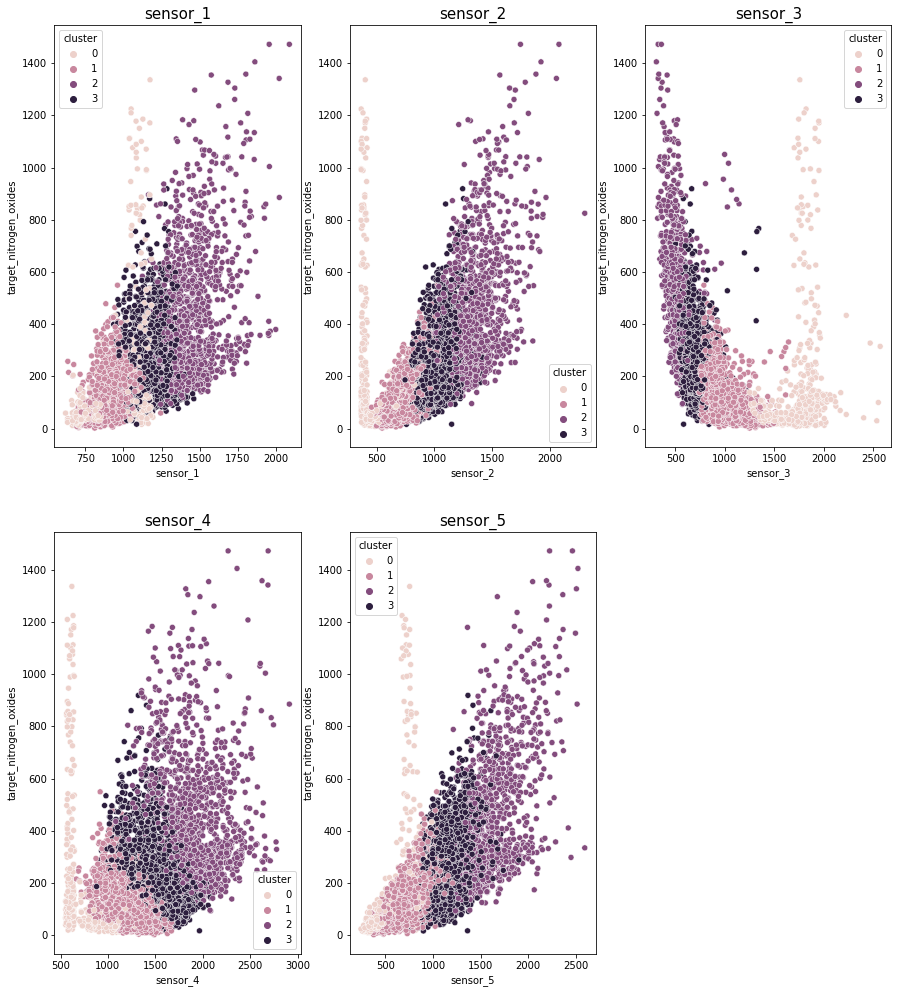

In [ ]:
plt.figure(figsize=(15,12))
for i,j in enumerate(['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5']):
  plt.subplot(3, 2, i+1)
  sns.scatterplot(x=train[j], y=train['target_nitrogen_oxides'], hue=train['cluster'])
  plt.title(f'{j}', fontsize=15)
plt.subplots_adjust(top=1.2)

# target : carbon_monoxide 모델링

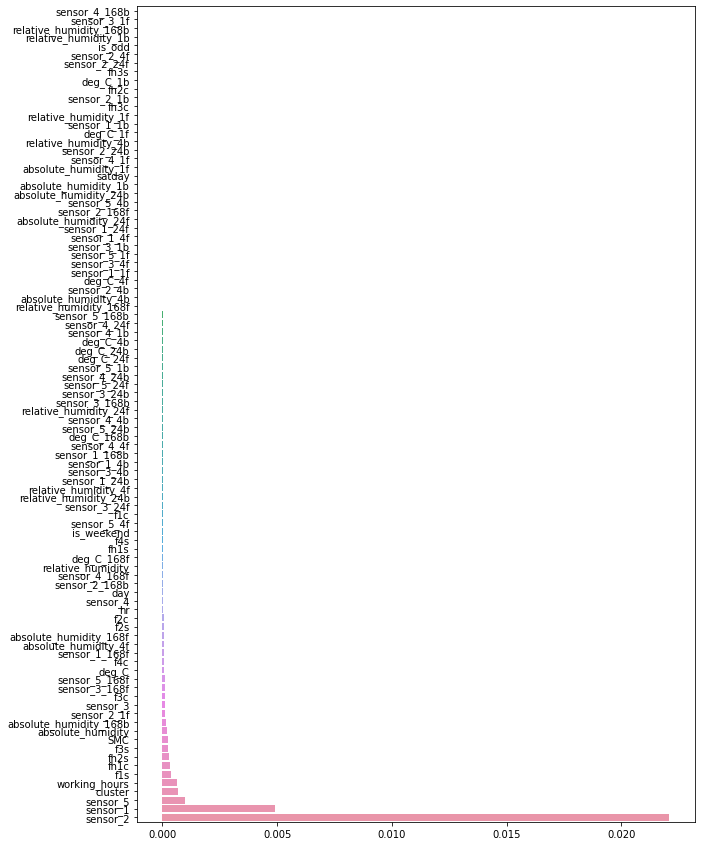

In [ ]:
# Feature Selection(Feature importance)
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y1_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostRegressor(loss_function='RMSE',
                                   eval_metric='RMSE',
                                   verbose=False,
                                   task_type='GPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_log_error, make_scorer
scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
perm = PermutationImportance(model_sel, scoring=scorer, random_state=12)
perm.fit(X_test, Y_test)

importance = pd.Series(perm.feature_importances_, index=x_train.columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)
drop_sel = importance.loc[importance<0].index

In [ ]:
# feature select ==> target1은 그냥 돌림
x_train_y1, x_test_y1 = x_train.drop(columns=importance.loc[importance<0].index), x_test.drop(columns=importance.loc[importance<0].index)

In [ ]:
cat_features = x_train.select_dtypes('object').columns

def objective(trial,data=x_train,target=y1_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Lossguide',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-07-29 04:02:49,176] A new study created in memory with name: no-name-0d00e652-387f-4c12-a3f6-48da2f4deb9f
[I 2021-07-29 04:03:58,966] Trial 0 finished with value: 0.05238352076058844 and parameters: {'iterations': 7632, 'learning_rate': 0.36554492664699184, 'reg_lambda': 18.594008034263712, 'subsample': 0.8503214478779455, 'random_strength': 10.499587818183599, 'depth': 8, 'min_data_in_leaf': 16, 'leaf_estimation_iterations': 14}. Best is trial 0 with value: 0.05238352076058844.
[I 2021-07-29 04:04:33,757] Trial 1 finished with value: 0.04564206300507936 and parameters: {'iterations': 21955, 'learning_rate': 0.10199425230174128, 'reg_lambda': 12.097500119022914, 'subsample': 0.8118897879646625, 'random_strength': 11.849647701827486, 'depth': 11, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 14}. Best is trial 1 with value: 0.04564206300507936.
[I 2021-07-29 04:05:00,952] Trial 2 finished with value: 0.059641687057666405 and parameters: {'iterations': 13405, 'learning_ra

Number of finished trials: 50
Best trial: score 0.04463303549326399, params {'iterations': 17093, 'learning_rate': 0.019356916012159636, 'reg_lambda': 99.89893160513864, 'subsample': 0.6293823737421217, 'random_strength': 10.210455132363068, 'depth': 6, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 15}


In [ ]:
cat_features = x_train.select_dtypes('object').columns
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=7, shuffle=True, random_state=42)
logo = LeaveOneGroupOut()
n_splits = months.nunique()
preds_cat_1 = np.zeros((x_test.shape[0],))
param_y1 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Lossguide',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(logo.split(x_train, y1_train, months)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y1_train.iloc[train_index], y1_train.iloc[valid_index]

  model_cat_1 = catboost.CatBoostRegressor(**param_y1)
  model_cat_1.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_1 += model_cat_1.predict(x_test)/n_splits
  preds_cat_val = model_cat_1.predict(X_valid)
  RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
  print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

0:	learn: 0.4226168	test: 0.1511025	best: 0.1511025 (0)	total: 28.1ms	remaining: 7m 59s
100:	learn: 0.1355705	test: 0.0314867	best: 0.0292498 (71)	total: 2.71s	remaining: 7m 35s
bestTest = 0.02924978724
bestIteration = 71
1번째 RMSLE:0.026214432438245283
0:	learn: 0.4248182	test: 0.3932459	best: 0.3932459 (0)	total: 25.9ms	remaining: 7m 22s
100:	learn: 0.1372921	test: 0.1196988	best: 0.1196988 (100)	total: 2.57s	remaining: 7m 12s
200:	learn: 0.0972460	test: 0.0924240	best: 0.0924240 (200)	total: 5.02s	remaining: 7m 2s
300:	learn: 0.0844497	test: 0.0881806	best: 0.0881805 (297)	total: 7.46s	remaining: 6m 56s
400:	learn: 0.0768012	test: 0.0861801	best: 0.0861801 (400)	total: 9.91s	remaining: 6m 52s
500:	learn: 0.0711543	test: 0.0853086	best: 0.0853086 (500)	total: 12.4s	remaining: 6m 51s
600:	learn: 0.0666332	test: 0.0843955	best: 0.0843955 (600)	total: 15s	remaining: 6m 51s
700:	learn: 0.0627174	test: 0.0840108	best: 0.0839729 (690)	total: 17.5s	remaining: 6m 50s
800:	learn: 0.0591882	tes

# target_benzene 모델링

In [ ]:
# Feature Selection(Feature importance)
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y2_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostRegressor(loss_function='RMSE',
                                   eval_metric='RMSE',
                                   verbose=False,
                                   task_type='CPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_log_error, make_scorer
scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
perm = PermutationImportance(model_sel, scoring=scorer, random_state=12)
perm.fit(X_test, Y_test)

importance = pd.Series(perm.feature_importances_, index=x_train.columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)
drop_sel = importance.loc[importance<0].index

ValueError: ignored

In [ ]:
x_train_y2 = x_train.drop(columns=importance.loc[importance < 0].index)
x_test_y2 = x_test.drop(columns=importance.loc[importance < 0].index)

In [ ]:
cat_features_y2 = x_train_y2.select_dtypes('object').columns
def objective(trial,data=x_train_y2,target=y2_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'cat_features' : cat_features_y2
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSE = np.sqrt(mean_squared_error(y_test, y_preds))
    
    return RMSE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-07-29 05:06:13,230] A new study created in memory with name: no-name-d2cdf4cf-5173-485f-95a9-298f16c51e6c
[I 2021-07-29 05:06:15,496] Trial 0 finished with value: 0.0839511519648693 and parameters: {'iterations': 7415, 'learning_rate': 0.35806265605528226, 'reg_lambda': 51.69546692967742, 'subsample': 0.4390670172957306, 'random_strength': 16.04822866680575, 'depth': 8, 'min_data_in_leaf': 24, 'leaf_estimation_iterations': 1}. Best is trial 0 with value: 0.0839511519648693.
[I 2021-07-29 05:06:19,636] Trial 1 finished with value: 0.09304782742718462 and parameters: {'iterations': 8087, 'learning_rate': 0.4403674956002884, 'reg_lambda': 97.70982355150306, 'subsample': 0.155495873494215, 'random_strength': 46.0563459339335, 'depth': 11, 'min_data_in_leaf': 17, 'leaf_estimation_iterations': 12}. Best is trial 0 with value: 0.0839511519648693.
[I 2021-07-29 05:07:33,693] Trial 2 finished with value: 0.08154011787937247 and parameters: {'iterations': 4614, 'learning_rate': 0.1082822

Number of finished trials: 50
Best trial: score 0.07442749020627551, params {'iterations': 9709, 'learning_rate': 0.022260830852806834, 'reg_lambda': 0.9712944824597854, 'subsample': 0.17085854768658237, 'random_strength': 35.24154654164272, 'depth': 7, 'min_data_in_leaf': 21, 'leaf_estimation_iterations': 6}


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=7, shuffle=True, random_state=42)
logo = LeaveOneGroupOut()
n_splits = months.nunique()
preds_cat_2 = np.zeros((x_test_y2.shape[0],))
param_y2 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Depthwise',
             'cat_features' : cat_features_y2
    
}

for i,(train_index, valid_index) in enumerate(logo.split(x_train_y2, y2_train, months)):
  X_train, X_valid = x_train_y2.iloc[train_index], x_train_y2.iloc[valid_index]
  Y_train, Y_valid = y2_train.iloc[train_index], y2_train.iloc[valid_index]

  model_cat2 = catboost.CatBoostRegressor(**param_y2)
  model_cat2.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_2 += model_cat2.predict(x_test_y2)/n_splits
  preds_cat_val = model_cat2.predict(X_valid)
  RMSLE = np.sqrt(mean_squared_log_error(Y_valid, preds_cat_val))
  print(f'{i+1}번째 RMSLE:{RMSLE}')

0:	learn: 0.7448508	test: 0.5303957	best: 0.5303957 (0)	total: 15.4ms	remaining: 2m 29s
100:	learn: 0.1173573	test: 0.2265546	best: 0.2265546 (100)	total: 1.51s	remaining: 2m 23s
200:	learn: 0.0754206	test: 0.2172931	best: 0.2161936 (154)	total: 2.9s	remaining: 2m 17s
300:	learn: 0.0690618	test: 0.2105292	best: 0.2096933 (262)	total: 4.18s	remaining: 2m 10s
400:	learn: 0.0656567	test: 0.2083371	best: 0.2073337 (351)	total: 5.44s	remaining: 2m 6s
500:	learn: 0.0631144	test: 0.2051677	best: 0.2039588 (474)	total: 6.67s	remaining: 2m 2s
bestTest = 0.2039587534
bestIteration = 474
1번째 RMSLE:0.07532141984795448
0:	learn: 0.7500732	test: 0.6727654	best: 0.6727654 (0)	total: 15.9ms	remaining: 2m 34s
100:	learn: 0.1174945	test: 0.1132614	best: 0.1132614 (100)	total: 1.46s	remaining: 2m 18s
200:	learn: 0.0749197	test: 0.0862941	best: 0.0862941 (200)	total: 2.82s	remaining: 2m 13s
300:	learn: 0.0685842	test: 0.0842051	best: 0.0842032 (299)	total: 4.13s	remaining: 2m 8s
400:	learn: 0.0650024	test

# target_nitrogen_oxides 모델링

In [ ]:
# Feature Selection(Feature importance)
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y3_train, test_size=0.2, shuffle=True, random_state=10)
model_sel = catboost.CatBoostRegressor(loss_function='RMSE',
                                   eval_metric='RMSE',
                                   verbose=False,
                                   task_type='GPU')
model_sel.fit(X_train, Y_train, eval_set=(X_test, Y_test), verbose=False)

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_log_error, make_scorer
scorer = make_scorer(mean_squared_log_error, greater_is_better=False)
perm = PermutationImportance(model_sel, scoring=scorer, random_state=12)
perm.fit(X_test, Y_test)

importance = pd.Series(perm.feature_importances_, index=x_train.columns).sort_values()
plt.figure(figsize=(10,15))
sns.barplot(y=importance.index, x=importance)
drop_sel = importance.loc[importance<0].index

In [ ]:
x_train_y3 = x_train.drop(columns=importance.loc[importance < 0].index)
x_test_y3 = x_test.drop(columns=importance.loc[importance < 0].index)

In [ ]:
def objective(trial,data=x_train,target=y3_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 25000),
             'loss_function':'RMSE',
              'task_type':"GPU",
              'eval_metric':'RMSE',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,12),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
              'cat_features' : cat_features
               }
    model = catboost.CatBoostRegressor(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict(X_test)


    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_preds))
    
    return RMSLE

In [ ]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-07-29 05:37:08,739] A new study created in memory with name: no-name-b5f45559-eb22-4f73-a46e-acce1422e688
[I 2021-07-29 05:37:16,896] Trial 0 finished with value: 0.03779648580810089 and parameters: {'iterations': 2016, 'learning_rate': 0.14464945596106907, 'reg_lambda': 0.7100518450959209, 'subsample': 0.6214219870889884, 'random_strength': 37.55589035197035, 'depth': 7, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 4}. Best is trial 0 with value: 0.03779648580810089.
[I 2021-07-29 05:37:38,485] Trial 1 finished with value: 0.038203877793604936 and parameters: {'iterations': 15500, 'learning_rate': 0.15341718926303774, 'reg_lambda': 30.473433392056318, 'subsample': 0.3238913046043377, 'random_strength': 15.83007514214085, 'depth': 2, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 7}. Best is trial 0 with value: 0.03779648580810089.
[I 2021-07-29 05:37:42,907] Trial 2 finished with value: 0.043573614845518506 and parameters: {'iterations': 7796, 'learning_rate': 

Number of finished trials: 50
Best trial: score 0.03516020283092036, params {'iterations': 9094, 'learning_rate': 0.012918903547444332, 'reg_lambda': 88.99825126514114, 'subsample': 0.5101210221349911, 'random_strength': 28.335585905130234, 'depth': 5, 'min_data_in_leaf': 2, 'leaf_estimation_iterations': 13}


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kf = KFold(n_splits=7, shuffle=True, random_state=42)
logo = LeaveOneGroupOut()
n_splits = months.nunique()
preds_cat_3 = np.zeros((x_test.shape[0]))
param_y3 = {'iterations':study.best_params['iterations'],
             'loss_function':'RMSE',
             'task_type':"GPU",
             'eval_metric':'RMSE',
             'leaf_estimation_method':'Newton',
             'bootstrap_type': 'Bernoulli',
             'learning_rate' : study.best_params['learning_rate'],
             'reg_lambda': study.best_params['reg_lambda'],
             'subsample': study.best_params['subsample'],
             'random_strength': study.best_params['random_strength'],
             'depth': study.best_params['depth'],
             'min_data_in_leaf': study.best_params['min_data_in_leaf'],
             'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
             'grow_policy' : 'Depthwise',
             'cat_features' : cat_features
    
}

for i,(train_index, valid_index) in enumerate(logo.split(x_train, y3_train, months)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y3_train.iloc[train_index], y3_train.iloc[valid_index]

  model_cat3 = catboost.CatBoostRegressor(**param_y3)
  model_cat3.fit(X_train, Y_train.ravel(), eval_set=(X_valid, Y_valid), early_stopping_rounds=70, verbose=100)

  preds_cat_3 += model_cat3.predict(x_test)/n_splits
  preds_cat_val = model_cat3.predict(X_valid)
  RMSLE = mean_squared_log_error(Y_valid, preds_cat_val)
  print(f'{i+1}번째 RMSLE:{np.sqrt(RMSLE)}')

NameError: ignored

Text(0.5, 1.0, 'Feature Importances for each targets')

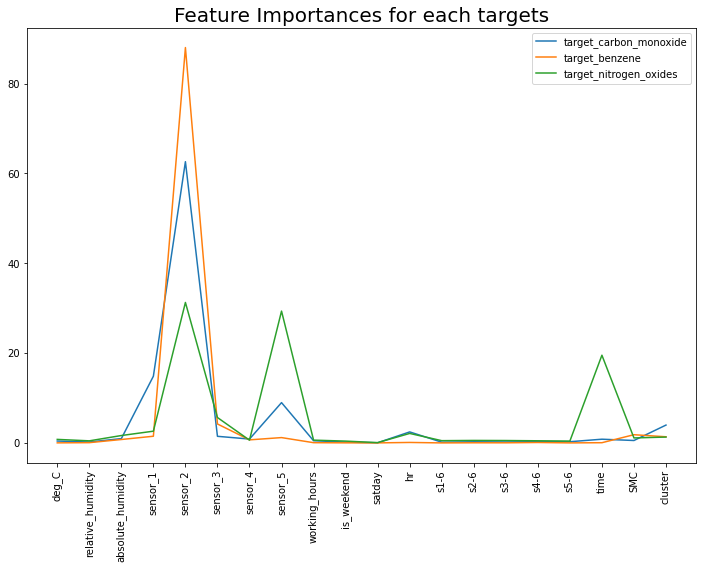

In [ ]:
# feature importance 시각화
model1_fi = pd.Series(model_cat_1.feature_importances_, index=x_train.columns)
model2_fi = pd.Series(model_cat_2.feature_importances_, index=x_train.columns)
model3_fi = pd.Series(model_cat_3.feature_importances_, index=x_train.columns)


plt.figure(figsize=(12,8))
plt.plot(model1_fi.index, model1_fi, label='target_carbon_monoxide')
plt.plot(model2_fi.index, model2_fi, label='target_benzene')
plt.plot(model3_fi.index, model3_fi, label='target_nitrogen_oxides')
plt.xticks(rotation=90)
plt.legend()
plt.title('Feature Importances for each targets', fontsize=20)

# Submit

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/tabular-playground-series-jul-2021_sample_submission.csv')
submit = submit.set_index('date_time')

submit['target_carbon_monoxide'] = preds_cat_1  # log1p()의 역수 == expm1
submit['target_benzene'] = preds_cat_2
submit['target_nitrogen_oxides'] = preds_cat_3

submit

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
date_time,,,
2011-01-01 00:00:00,1.655449,4.905823,228.821317
2011-01-01 01:00:00,2.155749,7.717947,290.240014
2011-01-01 02:00:00,1.799790,7.111851,261.442544
2011-01-01 03:00:00,1.785093,7.464699,269.346803
2011-01-01 04:00:00,1.247650,5.480143,181.458261
...,...,...,...
2011-04-04 10:00:00,3.035462,14.473620,455.430377
2011-04-04 11:00:00,2.383010,11.418168,375.980791
2011-04-04 12:00:00,2.402869,12.427098,334.413038


In [ ]:
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-jul/submit53.csv')

# conclusion

* 시계열 feature 들은 hour, weekday, weekend, time(datetime을 숫자화)로 만족
* month는 overfitting
* shuffle = True 하니까 점수 상승 == 왜 시계열인데 False로 하면 점수가 나빠질까?
* object화 하니까 점수 상승
* clustering(sensor_) 하니까 점수 상승
* time stamp 사용 점수 대폭 상승
* dewpoint는 점수 하락
* target_2에서 feature_selection 하니까 점수 약간 상승
* feature engineering 하고 LeaveOneGroupOut 쓰니까 점수 하락
* kfold도 해보기 ==> 새로운 피쳐 엔지니어링에서는 안 좋음
* 변수를 더 늘리진 말자 오버피팅 날뿐...

# To_do

 * 다른 모델 써보기

 * 변수 변환(로그변환, normalize)

 * catboost 튜닝 하지 말고 사용해보기

 * pseudo_label



 






```
# p-value, t-value

각 독립 변수의 p-값은 변수가 종속 변수와 상관 관계가 없다는 귀무 가설을 검정합니다.
p-값이 작다는 것은 귀무 가설이 거짓임을 나타냅니다. 
검정을 기각하기 위해 p-값이 얼마나 작은지 미리 결정하는 것이 좋습니다.
P-값과 t-값은 불가분의 관계에 있다. 
T-값은 표본 데이터의 변동에 상대적인 차이의 크기를 측정합니다. 
T의 크기가 클수록 귀무 가설에 대한 증거가 커진다. 
이것은 중요한 차이가 있다는 더 큰 증거가 있다는 것을 의미한다. 
T가 0에 가까울수록 큰 차이가 없을 가능성이 높습니다.

target_nitrogen_oxides에 대한 회귀 분석 출력은 변수의 p-값이 0.000이기 때문에 변수가 통계적으로 유의하다는 것을 보여 줍니다. 
반면 'sensor_1'은 p-값(0.99)이 일반적인 유의 수준 0.05보다 크므로 통계적으로 유의하지 않으며 이 열을 삭제해도 됩니다.
```

